In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt

import shap

from utils import plot_pca

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor


In [2]:
# load data
df = pd.read_csv('../data/EDD_isoprenol_production.csv', index_col=0)
df.drop('Measurement Type', axis=1, inplace=True)

# Split the data into X and y
X = df.drop('Value', axis=1).copy()
X = X.astype('int64')
y = df['Value'].copy()

df.head(3)

,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
Line Name,,,,,,,,,
Strain 1,0.000000,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0
Strain 2,0.552101,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0
Strain 3,0.349196,1.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0


In [3]:
# # Perfrom PCA on the data
# pca = PCA(n_components=2)
# pca_df = pd.DataFrame(pca.fit_transform(df.drop('Value', axis=1)), index=df.index, columns=['PC1', 'PC2'])
# pca_df.index = df.index
# pca_df['Value'] = df['Value']
# # Plot the PCA
# plot_pca(pca_df, pca)

In [4]:
# Train and tune an XGBoost model using optuna
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda',1e-4, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_jobs': -1,
        'random_state': 42
    }
    
    xgb = XGBRegressor(**params)
    scores = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Train the model on the entire dataset
params = study.best_trial.params
xgb_model = XGBRegressor(**params)
xgb_model.fit(X, y)


[I 2024-01-08 14:40:38,832] A new study created in memory with name: no-name-56475b62-7075-4e9d-bb39-bd5b42ce8a9b
[I 2024-01-08 14:40:43,547] Trial 0 finished with value: 0.39749668367293606 and parameters: {'n_estimators': 17, 'max_depth': 23, 'learning_rate': 0.006372210443606914, 'subsample': 0.8404674610304503, 'colsample_bytree': 0.7302670443509471, 'gamma': 0.18940613569119547, 'reg_alpha': 0.00033380643146982815, 'reg_lambda': 0.0019404728587846247, 'min_child_weight': 2}. Best is trial 0 with value: 0.39749668367293606.
[I 2024-01-08 14:40:45,419] Trial 1 finished with value: 5.780145658769486e+32 and parameters: {'n_estimators': 100, 'max_depth': 16, 'learning_rate': 3.1506358792053417, 'subsample': 0.6426906680901425, 'colsample_bytree': 0.9733342235616065, 'gamma': 0.181904269591875, 'reg_alpha': 0.00020556352780250377, 'reg_lambda': 0.000716465136465644, 'min_child_weight': 5}. Best is trial 0 with value: 0.39749668367293606.
[I 2024-01-08 14:40:47,585] Trial 2 finished wit

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9039585619969728, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0004261786887258046, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.16897000950574328, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=98, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

RMSE = 0.0584
STD = 0.0032


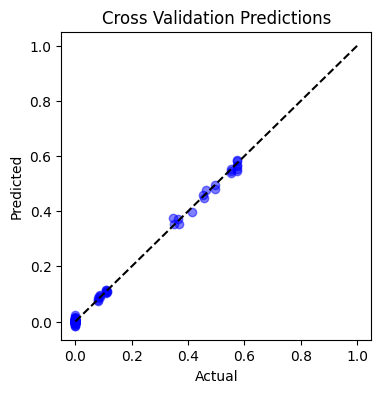

In [5]:
# Cross validate model on the data
def train(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    print(f'RMSE = {np.round(np.sqrt(np.abs(scores.mean())),4)}')
    print(f'STD = {np.round(scores.std(),4)}')
    model.fit(X, y)
    return model

def plot_R2(model, X, y):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(y, model.predict(X), color='blue', alpha=0.5)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Cross Validation Predictions')
    plt.show()

xgb = train(xgb_model, X, y)
plot_R2(xgb, X, y)

In [6]:
# Save the model
with open('../models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

### SHAP

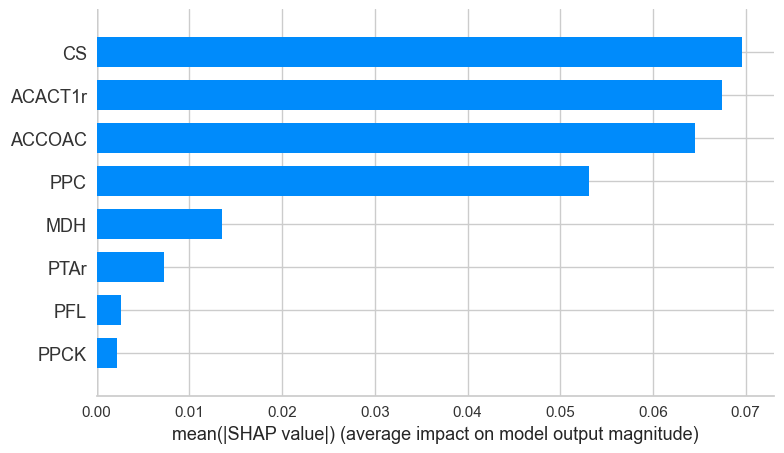

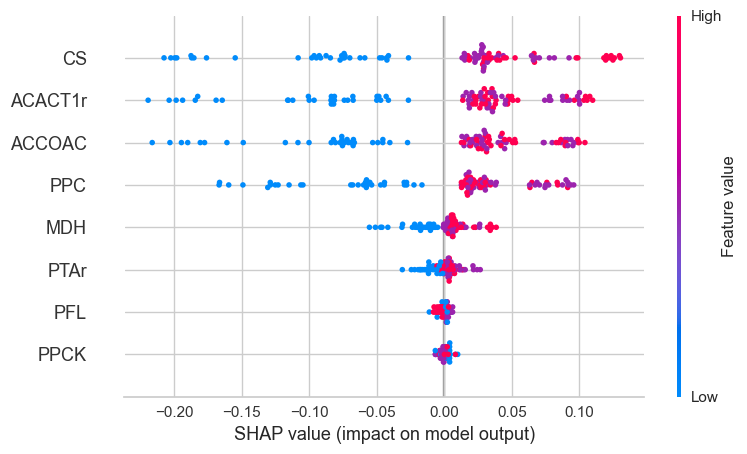

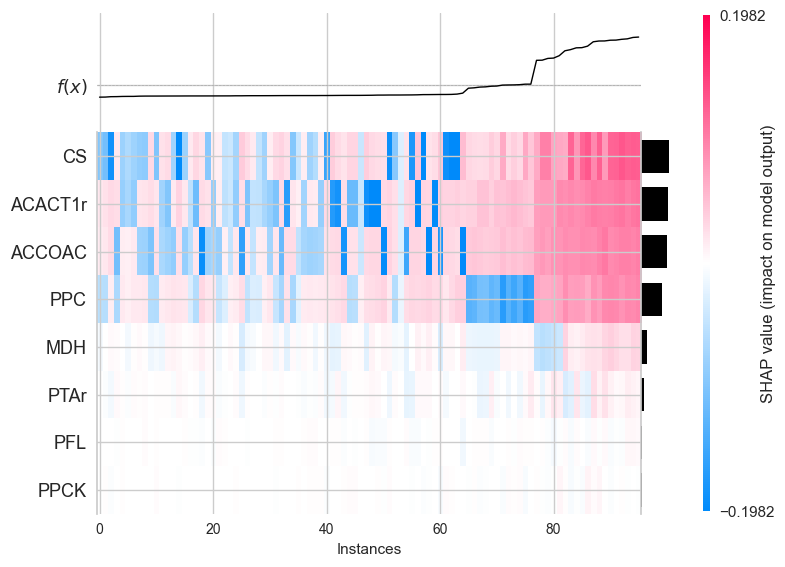

In [23]:
def shap_plots(model, X):
    # Calculate SHAP values and plot
    explainer = shap.TreeExplainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type='bar')
    shap.summary_plot(shap_values, X, plot_type='dot')
    order = np.argsort(model.predict(X))
    shap.plots.heatmap(shap_values, instance_order=order)
    return explainer, shap_values

explainer, shap_values = shap_plots(xgb, X)
# Shap values to dataframe
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df.index = df.index

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

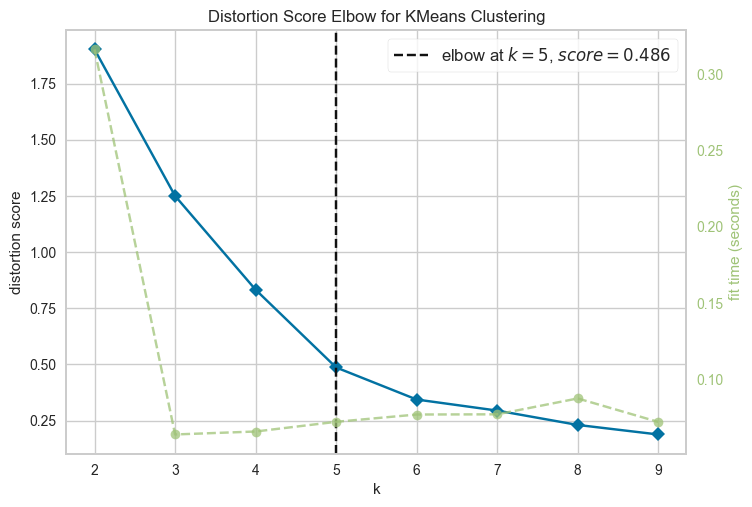

Optimal number of clusters = 5


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


In [9]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(shap_df)
visualizer.show()

# Get optimal number of clusters
n_clusters = visualizer.elbow_value_
print(f'Optimal number of clusters = {n_clusters}')

kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(shap_df)
shap_df['Cluster'] = kmeans.labels_
shap_df['Value'] = df['Value']

In [22]:
df['Cluster'] = shap_df['Cluster']
# groupy by cluster and calculate most common values
print('MOST COMMON VALUES')
display(df.groupby('Cluster').agg(lambda x:x.value_counts().index[0]))
# groupy by cluster and calculate mean values
print('MEAN VALUES')
display(df.groupby('Cluster').mean())
# groupy by cluster and calculate std values
print('STD VALUES')
display(df.groupby('Cluster').std())
# groupy by cluster and calculate median values
print('MEDIAN VALUES')
display(df.groupby('Cluster').median())

MOST COMMON VALUES


,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
Cluster,,,,,,,,,
0,0.552101,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0
1,0.000000,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0
2,0.000000,1.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0
3,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0


MEAN VALUES


,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
Cluster,,,,,,,,,
0,0.489407,1.473684,1.157895,1.052632,1.631579,1.368421,1.315789,1.000000,1.052632
1,0.000000,1.538462,0.846154,1.153846,1.615385,0.000000,0.923077,1.153846,1.000000
2,0.000000,1.357143,1.071429,1.000000,0.000000,1.642857,1.142857,1.214286,0.714286
3,0.048195,0.791667,0.791667,0.958333,1.291667,1.458333,0.500000,0.916667,0.916667
4,0.000000,0.423077,1.115385,0.923077,0.461538,0.461538,1.153846,0.923077,1.192308


STD VALUES


,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
Cluster,,,,,,,,,
0,0.085743,0.512989,0.834210,0.779864,0.495595,0.495595,0.477567,0.745356,0.848115
1,0.000000,0.518875,0.898717,0.800641,0.506370,0.000000,0.862316,0.898717,1.000000
2,0.000000,0.497245,0.828742,0.877058,0.000000,0.497245,0.949262,0.974961,0.726273
3,0.050254,0.883627,0.832971,0.858673,0.464306,0.508977,0.780189,0.775532,0.775532
4,0.000000,0.757526,0.765607,0.844894,0.760567,0.760567,0.784465,0.796145,0.800961


MEDIAN VALUES


,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
Cluster,,,,,,,,,
0,0.496425,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
1,0.000000,2.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0
2,0.000000,1.0,1.0,1.0,0.0,2.0,1.5,2.0,1.0
3,0.039323,0.5,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [17]:
df[df['Cluster'] == 0].sort_values(by='Value', ascending=False)

,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Cluster
Line Name,,,,,,,,,,
Strain 7,0.572648,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0
Strain 49,0.572648,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0
Strain 67,0.572648,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0
Strain 46,0.572648,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0
Strain 41,0.572648,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0
Strain 48,0.572648,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0
Strain 62,0.552734,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,0
Strain 2,0.552101,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0
Strain 4,0.551849,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0


## PDP & ICE

In [15]:
# Create mapping for the df columns
mapping = pd.DataFrame(columns=['Feature', 'index'])
mapping['Feature'] = X.columns
mapping['index'] = [i for i in range(len(X.columns))]
mapping.tail(3)

,Feature,index
5,PPC,5
6,PPCK,6
7,PFL,7


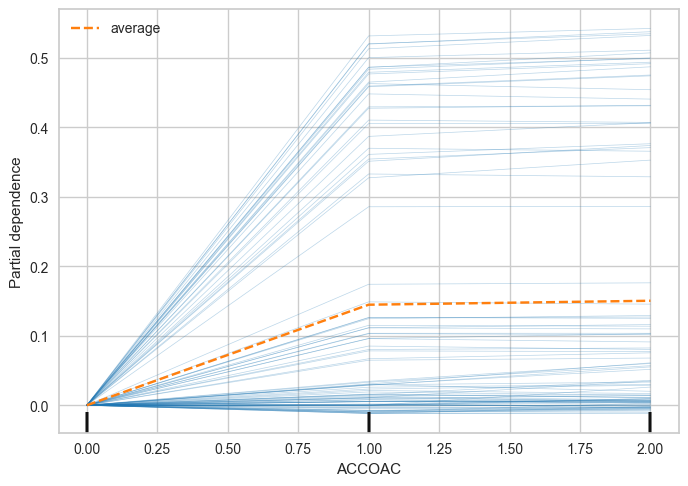

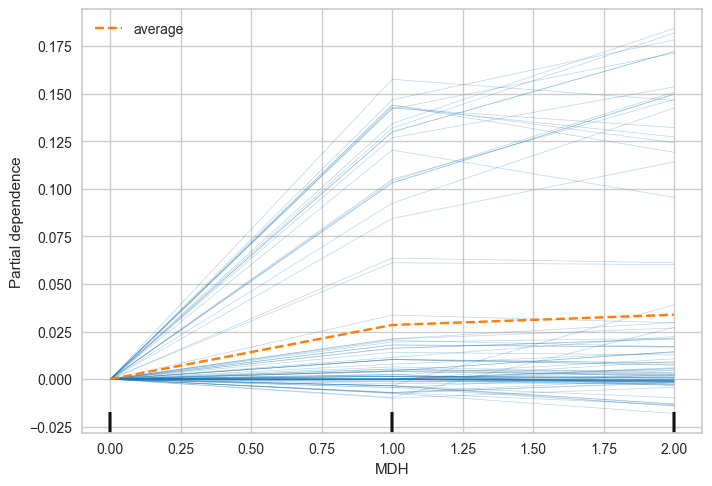

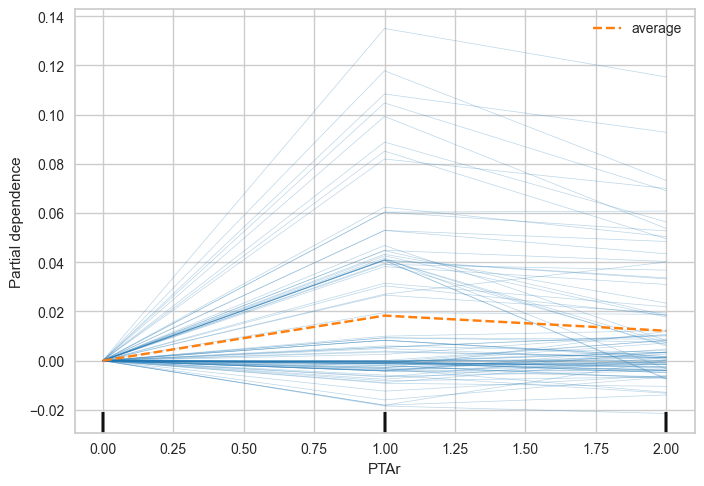

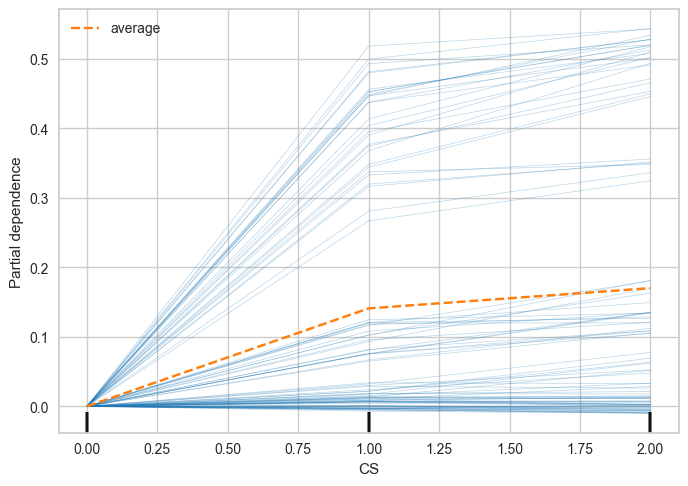

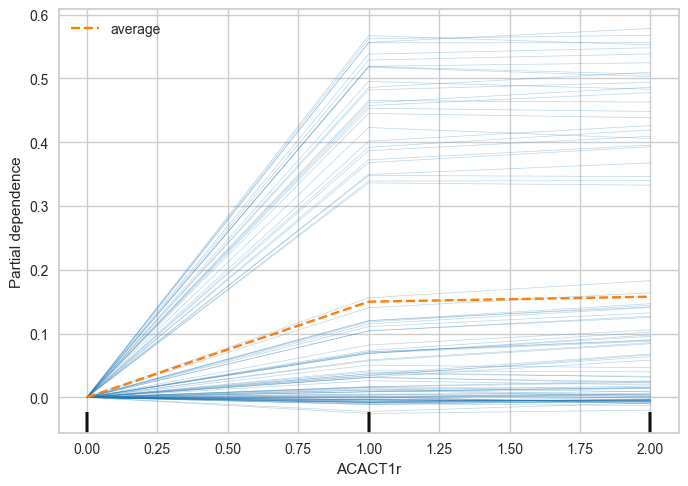

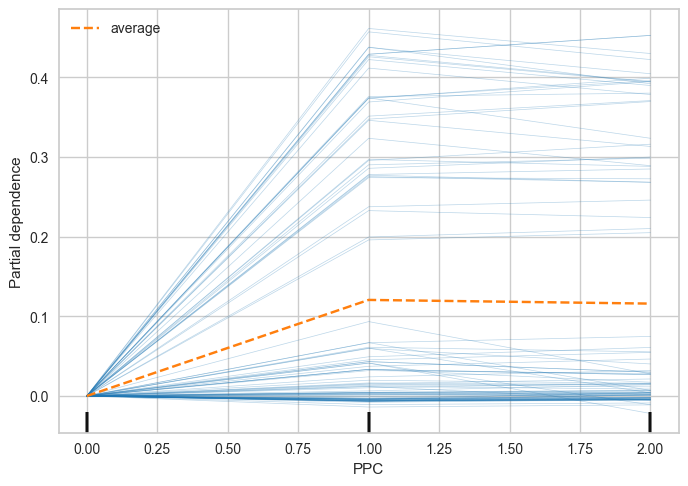

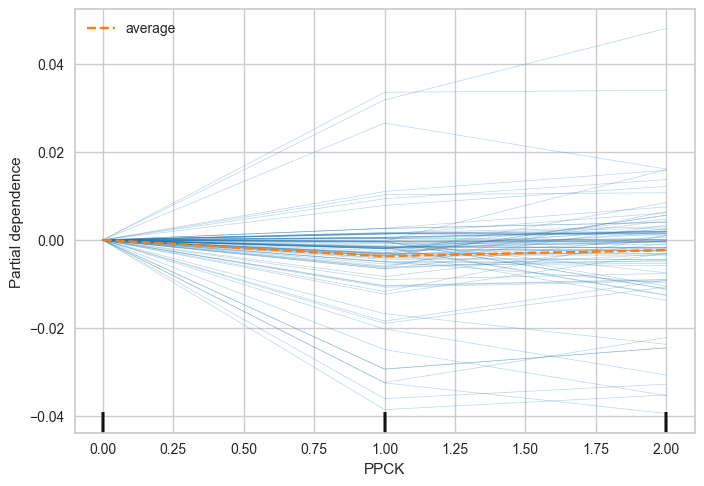

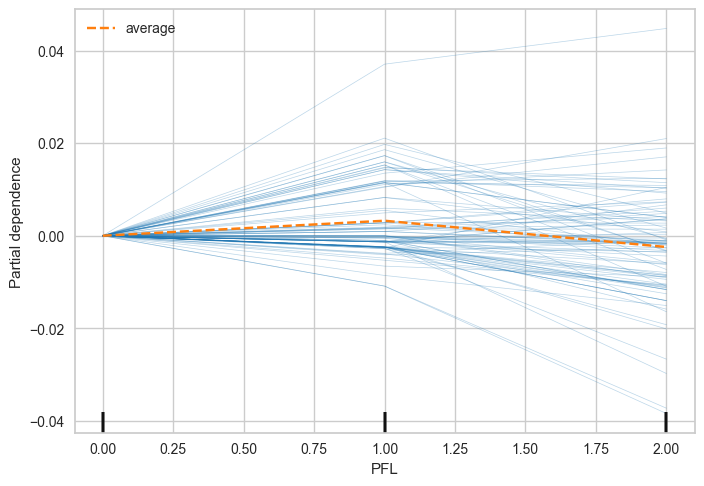

In [13]:
from sklearn.inspection import PartialDependenceDisplay

def plot_partial_dependence(model, X, col):
    idx = mapping[mapping['Feature'] == col]['index'].values[0]
    PartialDependenceDisplay.from_estimator(model, X, [col], kind='both', centered=True)
    plt.show()

for col in X.columns:
    plot_partial_dependence(xgb, X, col)

## LIME

In [ ]:
df['index'] = [i for i in range(len(df))]
df[df['Cluster']==0].sort_values(by='Value', ascending=False).head(10)

,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Cluster,index
Line Name,,,,,,,,,,,
Strain 7,0.572648,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0,6
Strain 49,0.572648,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0,48
Strain 67,0.572648,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0,66
Strain 46,0.572648,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0,45
Strain 41,0.572648,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0,40
Strain 48,0.572648,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0,47
Strain 62,0.552734,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,0,61
Strain 2,0.552101,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0,1
Strain 4,0.551849,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0,3


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
categorical_features = [i for i in range(len(X.columns))]
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns.values.tolist(),
                                                  verbose=True, mode='regression',  
                                                   categorical_features=categorical_features)
j = 6
exp = explainer.explain_instance(X.values[j], xgb.predict, num_features=8)
exp.show_in_notebook(show_table=True, show_all=True)
pd.DataFrame(exp.as_list(), columns=['Feature', 'Contribution'])

Intercept 0.005337633398832392
Prediction_local [0.29979472]
Right: 0.57773155


,Feature,Contribution
0,CS=2,0.103268
1,ACACT1r=2,0.074706
2,ACCOAC=2,0.055714
3,PPC=2,0.044318
4,MDH=1,0.009508
5,PTAr=2,0.009151
6,PPCK=0,-0.002357
7,PFL=2,0.000148


## OMLT

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress CUDA warnings from tensorflow

# import the necessary packages
from omlt import OmltBlock, OffsetScaling
from omlt.io.keras import load_keras_sequential
from omlt.neuralnet import ReluBigMFormulation
import pyomo.environ as pyo
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('../data/EDD_isoprenol_production.csv', index_col=0)
df.drop('Measurement Type', axis=1, inplace=True)
X = df.drop('Value', axis=1).copy()
y = df['Value'].copy()

In [ ]:
inputs = X.columns.values.tolist()
outputs = ['Value']

dfin = df[inputs]
dfout = df[outputs]

In [ ]:
# We scale the data for improved training, however, we want to formulate
# our optimizaton problem on the original variables. Therefore, we keep
# the scaling parameters to use later in our optimization formulation

x_offset, x_factor = dfin.mean().to_dict(), dfin.std().to_dict()
y_offset, y_factor = dfout.mean().to_dict(), dfout.std().to_dict()

dfin = (dfin - dfin.mean()).divide(dfin.std())
dfout = (dfout - dfout.mean()).divide(dfout.std())

# capture the minimum and maximum values of the scaled inputs
# so we don't use the model outside the valid range
scaled_lb = dfin.min()[inputs].values
scaled_ub = dfin.max()[inputs].values

In [ ]:
# create our Keras Sequential model
nn = Sequential(name='reformer_relu_4_20')
nn.add(Dense(units=50, input_dim=len(inputs), activation='relu'))
# nn.add(Dense(units=248, activation='relu'))
# nn.add(Dense(units=10, activation='relu'))
# nn.add(Dense(units=10, activation='relu'))
nn.add(Dense(units=len(outputs)))
nn.compile(optimizer=Adam(), loss='mse')

In [ ]:
X = dfin.values
y = dfout.values

history = nn.fit(X, y, epochs=100, validation_split=0.2, verbose=0)

In [ ]:
# Plot the loss function over time
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# first, create the Pyomo model
m = pyo.ConcreteModel()
# create the OmltBlock to hold the neural network model
m.reformer = OmltBlock()

# load the Keras model
# nn_reformer = keras.models.load_model('reformer_nn_relu', compile=False)
nn_reformer = nn

# Note: The neural network is in the scaled space. We want access to the
# variables in the unscaled space. Therefore, we need to tell OMLT about the
# scaling factors
scaler = OffsetScaling(
        offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
        factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
        offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
        factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
    )

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

# create a network definition from the Keras model
net = load_keras_sequential(nn_reformer, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds)

# create the variables and constraints for the neural network in Pyomo
m.reformer.build_formulation(ReluBigMFormulation(net))

In [ ]:
# add the objective and constraints
iso_idx = outputs.index('Value')
m.obj = pyo.Objective(expr=m.reformer.outputs[iso_idx], sense=pyo.maximize)

In [ ]:
# now solve the optimization problem (this may take some time)
solver = pyo.SolverFactory('gurobi')
status = solver.solve(m, tee=False)

In [ ]:
for i in range(len(inputs)):
    print(inputs[i], np.round(pyo.value(m.reformer.inputs[i])))

for i in range(len(outputs)):
    print('***')
    print(outputs[i], pyo.value(m.reformer.outputs[i]))